# Business Analysis on Loan Portfolio - Lending Club Default Prediction

For the business analysis, I have used the untouched new customers data I set aside during data preprocessing.<br><br>
This is a basic analysis to explain the approach of using a Machine Learning model to make business decisions.

In [149]:
#Analysis- Deep Borkar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from sklearn import ensemble


from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

In [150]:
new_customers = pd.read_csv('data/new_customers.csv', index_col = 0)
new_customers.drop(['loan_status'], axis=1, inplace=True)

The Risk-Free rate as of Dec - 2019 is used for estimating the interest rate for No arbitrage loans.

In [151]:
risk_free = 0.01895

In [152]:
business_GBM = pd.read_csv('business_analysis_data/business_GBM.csv', index_col=0)
business_NN = pd.read_csv('business_analysis_data/business_NN.csv', index_col=0)
business_LR = pd.read_csv('business_analysis_data/business_LR.csv', index_col=0)

### Calculating Bad Rate

Using the existing customers default probabilities, I put them in 10 buckets from 0 to 1 divided in 10 equal parts.<br><br>

For each bucket, the number of defaults is i considered as the Bad Rate

In [153]:
def calc_bad_rate(df):
    df['bucket'] = pd.cut(df['Default_Prob'], [i/10 for i in range(0,11)])

    def_bucket = df.groupby('bucket')['target'].value_counts().unstack()

    def_bucket['Bad_rate'] = def_bucket[1] / (def_bucket[0] + def_bucket[1])
    
    def_bucket['Rank'] = def_bucket['Bad_rate'].rank(method='min')
    return def_bucket

In [154]:
br_GBM = calc_bad_rate(business_GBM)
br_NN = calc_bad_rate(business_NN)
br_LR = calc_bad_rate(business_LR)

### Calculating Interest rate

For each bucket, an interest rate is calculated considering a payoff equivalent to a risk-free rate if the loan does not default.

In [155]:
def calc_interest(df):
    df['Interest_rate'] =  (((1+risk_free) / (1 -  df['Bad_rate'])) - 1)

In [156]:
calc_interest(br_GBM)
calc_interest(br_NN)
calc_interest(br_LR)

In [157]:
br_GBM

target,0,1,Bad_rate,Rank,Interest_rate
bucket,,,,,
"(0.0, 0.1]",570780,3706,0.006451,1.0,0.025566
"(0.1, 0.2]",10758,1489,0.121581,2.0,0.159981
"(0.2, 0.3]",3182,1093,0.255673,3.0,0.368954
"(0.3, 0.4]",1332,972,0.421875,4.0,0.762508
"(0.4, 0.5]",553,1000,0.643915,5.0,1.861536
"(0.5, 0.6]",299,1083,0.783647,6.0,3.709662
"(0.6, 0.7]",186,1355,0.879299,7.0,7.441946
"(0.7, 0.8]",154,1810,0.921589,8.0,11.994921
"(0.8, 0.9]",89,3081,0.971924,9.0,35.292938


Using the GBM Model for business analysis, I have chosen the cut-off of default probabilty of 0.3. <br> This can be considered as the future Credit policy while approving loans and assigning interest rates.
<br><br>
This is a simple approach to build a structure of decision making model.

In [158]:
credit_policy = br_GBM[0:3]
credit_policy

target,0,1,Bad_rate,Rank,Interest_rate
bucket,,,,,
"(0.0, 0.1]",570780,3706,0.006451,1.0,0.025566
"(0.1, 0.2]",10758,1489,0.121581,2.0,0.159981
"(0.2, 0.3]",3182,1093,0.255673,3.0,0.368954


In [159]:
business_GBM['Interest'] = business_GBM['bucket'].map(br_GBM['Interest_rate'])

In [160]:
business_GBM['term'] = business_GBM['term'].map({0:3, 1: 5})

### Calculating PMT

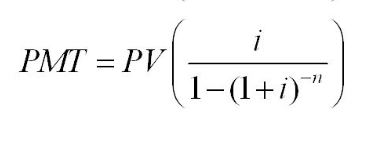

In [1]:
from IPython.display import Image, display
display(Image(filename='pmt.png'))

As we know the duration of each loan, we can use it to calculate the PMT - payment per period for each loan using the interest rates as per our Credit Policy.

In [161]:
business_GBM['PMT'] = (business_GBM['Interest'].astype(np.float64) * business_GBM['Loan_amt']) / (1 - ((1 + business_GBM['Interest'].astype(np.float64))**(-1*business_GBM['term'])))

In [162]:
business_GBM['bad_rate'] = business_GBM['bucket'].map(br_GBM['Bad_rate'])

In [163]:
business_GBM

,Default_Prob,Loan_amt,term,target,bucket,Interest,PMT,bad_rate
1379948,0.002871,4000,3,0,"(0.0, 0.1]",0.025566,1.402083e+03,0.006451
2003149,0.107010,27450,5,1,"(0.1, 0.2]",0.159981,8.383125e+03,0.121581
1164725,0.013710,33100,5,0,"(0.0, 0.1]",0.025566,7.136282e+03,0.006451
1085009,0.995184,4800,3,1,"(0.9, 1.0]",1072.956317,5.150190e+06,0.999051
264018,0.000874,3500,3,0,"(0.0, 0.1]",0.025566,1.226822e+03,0.006451
...,...,...,...,...,...,...,...,...
1828742,0.004307,24000,3,0,"(0.0, 0.1]",0.025566,8.412496e+03,0.006451
1756567,0.999998,12000,3,1,"(0.9, 1.0]",1072.956317,1.287548e+07,0.999051
1496409,0.999888,30000,5,1,"(0.9, 1.0]",1072.956317,3.218869e+07,0.999051
820691,0.960920,11000,3,1,"(0.9, 1.0]",1072.956317,1.180252e+07,0.999051


In [164]:
def load_model(name):
    name = 'models/' + name
    return pickle.load(open(name, 'rb'))

credit_model =  load_model('GBM_30_1.sav')

In [167]:
prob_default_newC.shape

(40134, 4)

In [168]:
prob_default_newC = pd.DataFrame(credit_model.predict_proba(new_customers)[:,1], index=new_customers.index, columns = ['Default_prob'])

prob_default_newC['Predicted_Status'] = credit_model.predict(new_customers)

prob_default_newC['Loan_amount'] = new_customers['loan_amnt']
prob_default_newC['Term'] = new_customers['term'] 

prob_default_newC['Term'] = prob_default_newC['Term'].map({0:3, 1: 5})

In [169]:
#reject_ind = prob_default_newC[prob_default_newC.Default_prob > credit_policy['Bad_rate'].iloc[2]].index
#prob_default_newC.drop(reject_ind, axis=0, inplace=True)

In [180]:
def assign_int(pd):
    cutoff_1, int_rt_1 = credit_policy['Bad_rate'].iloc[0], credit_policy['Interest_rate'].iloc[0]
    cutoff_2, int_rt_2 = credit_policy['Bad_rate'].iloc[1], credit_policy['Interest_rate'].iloc[1]
    cutoff_3, int_rt_3 = credit_policy['Bad_rate'].iloc[2], credit_policy['Interest_rate'].iloc[2]
    
    if pd > 0 and pd <= cutoff_1:
        return int_rt_1
    elif pd > cutoff_1 and pd <= cutoff_2:
        return int_rt_2
    elif pd > cutoff_2: #and pd <= cutoff_3:
        return int_rt_3
    else:
        return np.nan

int_list = []
for i in range(prob_default_newC.shape[0]):
    int_list.append(assign_int(prob_default_newC.Default_prob.iloc[i]))
    
prob_default_newC['Interest_rate'] = int_list

In [181]:
prob_default_newC['PMT'] = (prob_default_newC['Interest_rate'].astype(np.float64) * prob_default_newC['Loan_amount']) / (1 - ((1 + prob_default_newC['Interest_rate'].astype(np.float64))**(-1*prob_default_newC['Term'])))
prob_default_newC['PMT'] = prob_default_newC['PMT'].round(2)

### Calculating Net Present Value

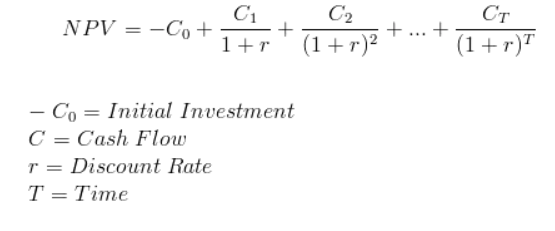

In [2]:
from IPython.display import Image, display
display(Image(filename='npv.png'))

Using the Credit Policy and PMT, we can find out the Net Present Value (NPV) for each loan.<br><br>
Initial Investment = Loan Amount <br>
Cash Flow = PMT each period<br>
r = risk-free rate <br><br>
Every Cash Flow is discounted to check if the loan funded will be profitable or not.

In [182]:
def calc_NPV(pmt, dr, cf0, pd, t):
    cfs = [cf0]
    pnd = 1 - pd
    for n in range(1,t+1):
        pvcf = (pmt * (pnd ** n)) / ((1 + risk_free)**n)
        cfs.append(pvcf)
    return sum(cfs)    

In [183]:
prob_default_newC.Predicted_Status.value_counts()

0    40118
1       16
Name: Predicted_Status, dtype: int64

In [184]:
npv = []
for i in tqdm(range(prob_default_newC.shape[0])):
    inst = prob_default_newC['PMT'].iloc[i]
    cf0 = prob_default_newC['Loan_amount'].iloc[i] * -1
    pd = prob_default_newC['Default_prob'].iloc[i]
    t = prob_default_newC['Term'].iloc[i]
    npv.append(calc_NPV(inst, risk_free, cf0, pd, t))

In [185]:
prob_default_newC['NPV'] = npv

In [190]:
prob_default_newC.NPV.sum()

12250113.54426239

In [191]:
prob_default_newC.Loan_amount.sum()

637843075

### Calculating Overall Loan Portfolio Return

The Loan Portfolio Return is marginally higher than the risk-free rate. This is due to the interest income earned. 

In [192]:
12250113.54426239 / 637843075

0.019205528796032458

In [195]:
npv_br = prob_default_newC.groupby('Interest_rate')['NPV'].sum().to_frame()

,NPV
Interest_rate,
0.025566,9.483046e+06
0.159981,2.630719e+06
0.368954,1.363479e+05


In [198]:
npv_br['Bad_rate'] = credit_policy['Bad_rate'].values

In [199]:
npv_br

,NPV,Bad_rate
Interest_rate,,
0.025566,9.483046e+06,0.006451
0.159981,2.630719e+06,0.121581
0.368954,1.363479e+05,0.255673


### Conclusion

The purpose of this project is to learn from implementation of Data Science and Machine Learning concepts. It is important to apply these concepts in a real-world application.
<br>I would keep updating this project as I keep learning and researching new Machine Learning Techniques.

Created by: Deep Borkar<br>
Email: deepyborkar@gmail.com
Presentation: https://www.slideshare.net/DeepBorkar1/default-prediction-analysis-on-lending-club-loan-data